<div style="
  background:linear-gradient(90deg,#6366f1,#22c55e);
  color:white;
  padding:16px 22px;
  margin:30px 0 15px 0;
  font-size:30px;
  font-weight:700;
  border-radius:10px;
  box-shadow:0 8px 20px rgba(0,0,0,0.15);
  text-align:center;
">
<h1>End-to-End Face Emotion Recognition System</h1>
YOLO-based Face Detection + ResNet-based Emotion Classification
</div>

# Introduction

Facial emotion recognition is a challenging computer vision task that requires both accurate face localization and robust emotion classification. In real-world systems, these two components are often handled by seperate models and integrated into a single pipeline.

In this project, we build a complete end-to-end computer vision system where:

- Faces are detected using a YOLO-based object detector trained on a face detection dataset.
- Each detected face is cropped and preprocessed.
- A deep learning classifier predicts the emotion of each detected face.

The focus of this project is not only model accuracy, but also system design, modularity, and realistic evaluation, closely resembling industry-grade computer vision pipelines.

# Project Objectives

The main objectives of this project are:

- Build a modular, end-to-end facial emotion recognition pipeline
- Train a custom face detector instead of relying solely on pretrained weights
- Use transfer learning with partial fine-tuning for emotion classification
- perform qualitative and quantitative evaluation

# Overall Pipeline Design

- Input Image

- YOLO Face Detector (trained on WIDER FACE)

- Face Bounding Boxes

- Face Cropping + Preprocessing

- ResNet18 Emotion Classifier (partially fine-tuned)

- Emotion Label + Confidence Score


# Datasets Used

## 1) Face Detection Dataset

- WIDER FACE (YOLO format)

- Contains real-world images with large variations in pose, scale, occlusion, and lighting.

- Used to train a single-class face detector.

### Dataset structure includes:

- train/images, train/labels

- val/images, val/labels

- data.yaml for YOLO training configuration


## 2) Emotion Classification Dataset

- FER2013 (image-folder version)

- 7 emotion classes:
    - Angry
    - Disgust
    - Fear
    - Happy
    - Sad
    - Surprise
    - Neutral

The dataset is low-resolution and noisy, which makes it suitable for testing model robustness and overfitting behavior.

In [ ]:
!pip install -q ultralytics

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms, models
from collections import Counter
from tqdm import tqdm
import os
import cv2
from PIL import Image
import random

import warnings
warnings.filterwarnings("ignore")
from ultralytics import YOLO

# Exploratory Data Analysis

Before training the emotion classifier, we perform basic EDA to understand the dataset characteristics:

- Emotion class distribution (to identify imbalance)
- Visual inspection of sample images per emotion
- Observation of ambiguity between similar emotions (e.g., fear vs surprise)

This analysis helps explain later model behavior and misclassifications.

## Emotion class distribution

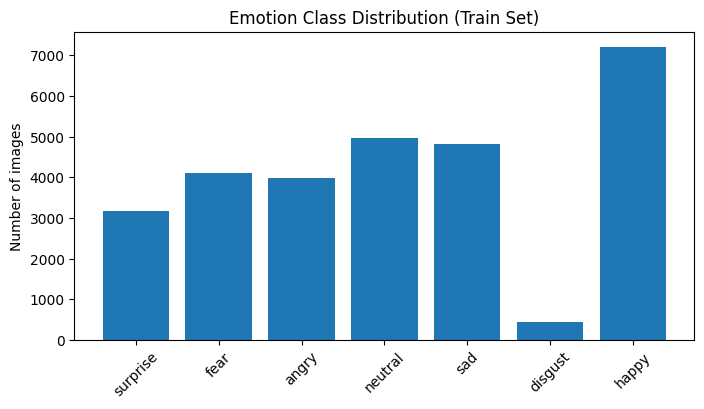

In [3]:

train_dir = "/kaggle/input/fer2013/train"

class_counts = {}
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

plt.figure(figsize=(8,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Emotion Class Distribution (Train Set)")
plt.xticks(rotation=45)
plt.ylabel("Number of images")
plt.show()


## Visual inspection of sample images per emotion

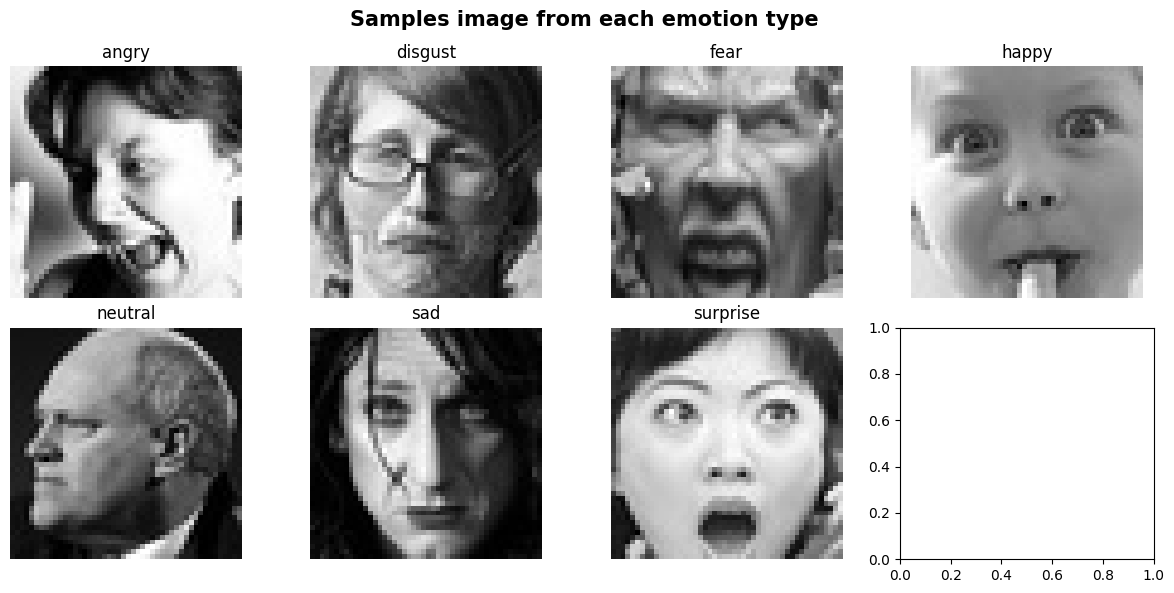

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(12,6))
axes = axes.flatten()

for idx, emotion in enumerate(sorted(os.listdir(train_dir))):
    img_dir = os.path.join(train_dir, emotion)
    img_name = random.choice(os.listdir(img_dir))
    img_path = os.path.join(img_dir, img_name)

    img = Image.open(img_path).convert("L")
    axes[idx].imshow(img, cmap="gray")
    axes[idx].set_title(emotion)
    axes[idx].axis("off")

plt.suptitle('Samples image from each emotion type', fontsize = 15, fontweight = 900)
plt.tight_layout()
plt.show()


<div style="
  background:linear-gradient(90deg,#6366f1,#22c55e);
  color:white;
  padding:16px 22px;
  margin:30px auto 15px auto;
  font-size:24px;
  font-weight:700;
  border-radius:10px;
  box-shadow:0 8px 20px rgba(0,0,0,0.15);
  text-align:center;
  width:50%;
">
  ResNet-based Emotion Classifier Training
</div>

#

Emotion classification is the second stage of the pipeline and operates on cropped face images. The goal of this model is to predict one of seven facial emotions from a single face image.

Rather than training a model from scratch, we adopt a transfer learning approach to leverage features learned from large-scale image datasets.

## Data Preprocessing & Augmentation

Since the selected backbone is pretrained on ImageNet (RGB images), grayscale FER images are converted into three-channel format.

The following preprocessing steps are applied:

- Grayscale to 3-channel conversion
- Resize to 224 × 224
- Normalization using ImageNet statistics

To improve generalization and reduce overfitting, data augmentation is applied during training:

- Random horizontal flipping
- Small rotations and affine transformations

These augmentations help the model handle minor variations in facial pose and expression.

In [10]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder(
    root="/kaggle/input/fer2013/train",
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root="/kaggle/input/fer2013/test",
    transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = len(train_dataset.classes)

## Model Architecture

The emotion classification model is based on ResNet18, a lightweight residual network well-suited for transfer learning.

Key architectural choices:

- Pretrained on ImageNet
- Final fully connected layer replaced to output 7 emotion classes
- Residual connections enable stable gradient flow

ResNet18 offers a good balance between performance and computational efficiency, making it suitable for real-time inference scenarios.

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ',device)


emotion_model = models.resnet18(weights = 'IMAGENET1K_V1')

emotion_model.fc = nn.Linear(emotion_model.fc.in_features, num_classes)

emotion_model = emotion_model.to(device)

device:  cuda


## Handling Class Imbalance

The FER2013 dataset exhibits a significant class imbalance, with emotions such as 'happy' and 'neutral' appearing far more frequently than others like 'disgust' or 'fear'. Ignoring this imbalance can cause the model to bias its predictions toward dominant classes.

To mitigate this issue, class-weighted loss is used.

Class weights are computed as the inverse frequency of each emotion class based on the training dataset. These weights are then passed to the loss function so that underrepresented classes contribute more strongly to the training signal.

In addition, label smoothing is applied to reduce the model's overconfidence and improve robustness to noisy emotion labels.

This combination helps stabilize training and improves generalization, especially for rare emotion classes.

In [31]:
targets = [label for _, label in train_dataset.samples]
class_counts = Counter(targets)

class_weights = torch.tensor(
    [1.0 / class_counts[i] for i in range(len(train_dataset.classes))],
    dtype=torch.float
).to(device)


criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.1
)


## Partial Fine-Tuning Strategy (Layer Unfreezing)

Rather than fully fine-tuning the entire network, a controlled partial fine-tuning approach is adopted to balance adaptability and overfitting risk.

- conv1
- layer1
- layer2
- layer3  <- unfreeze
- layer4  <- unfreeze
- fc  <- unfreeze

In [32]:
# Unfreeze layer3, layer4, and fc
for name, param in emotion_model.named_parameters():
    if (
        "layer3" in name or
        "layer4" in name or
        "fc" in name
    ):
        param.requires_grad = True
    else:
        param.requires_grad = False


## Optimization Strategy & Learning Rate Scheduling

Fine-tuning pretrained networks requires careful optimization to avoid destroying useful representations. To achieve this, **discriminative learning** rates are used.

Different learning rates are assigned to different parts of the network:

- Higher learning rate for the classification head (fc)
- Moderare learning rate for layer4
- Lower learning rate for layer3

This allows each component to adapt at an appropriate pace.

Additionally, a Reduce-on-Plateau learning rate scheduler is employed, which automatically reduces the learning rate when validation accuracy stops improving. This helps prevent unnecessary oscillations and supports smoother convergence.

Together, these optimization choices enable stable training while maintaining generalization performance.

In [33]:
optimizer = torch.optim.Adam([
    {"params": emotion_model.layer4.parameters(), "lr": 1e-4},
    {"params": emotion_model.layer3.parameters(), "lr": 5e-5},
    {"params": emotion_model.fc.parameters(),     "lr": 3e-4},
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2
)



In [34]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total


In [35]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return correct / total


In [36]:
train_acc_history = []
val_acc_history = []

best_val_acc = 0
best_epoch = 0

epochs = 5

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(emotion_model, train_loader)
    val_acc = evaluate(emotion_model, test_loader)

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Save best emotion_model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1  # 1-based index
        torch.save(emotion_model.state_dict(), "resnet18_emotion_best.pth")
        print(f'\nBest model saved! with acc: {val_acc}\n')

    print(
        f"Epoch {epoch+1}/{epochs} |  "
        f"Train Acc: {train_acc:.3f} | "
        f"Val Acc: {val_acc:.3f}")


100%|██████████| 449/449 [02:18<00:00,  3.25it/s]



Best model saved! with acc: 0.5621342992477013

Epoch 1/5 |  Train Acc: 0.443 | Val Acc: 0.562


100%|██████████| 449/449 [02:09<00:00,  3.46it/s]



Best model saved! with acc: 0.5624129283923098

Epoch 2/5 |  Train Acc: 0.566 | Val Acc: 0.562


100%|██████████| 449/449 [02:06<00:00,  3.54it/s]



Best model saved! with acc: 0.602256896071329

Epoch 3/5 |  Train Acc: 0.618 | Val Acc: 0.602


100%|██████████| 449/449 [02:05<00:00,  3.57it/s]



Best model saved! with acc: 0.6309556979660073

Epoch 4/5 |  Train Acc: 0.651 | Val Acc: 0.631


100%|██████████| 449/449 [02:05<00:00,  3.59it/s]


Epoch 5/5 |  Train Acc: 0.679 | Val Acc: 0.615


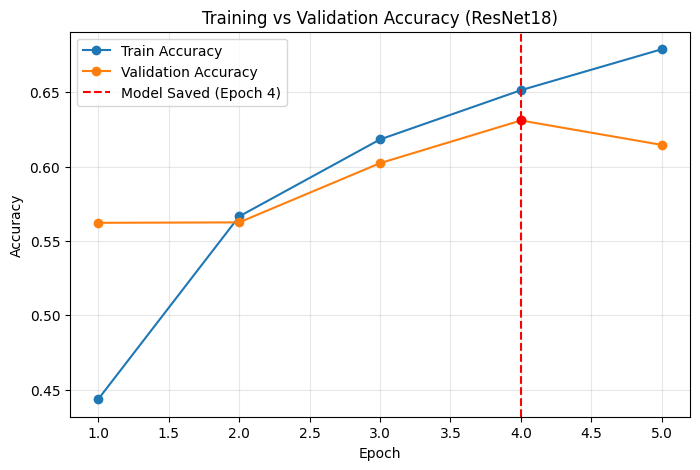

In [37]:
epochs_range = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_acc_history, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_acc_history, label="Validation Accuracy", marker="o")

# Mark saved model
plt.axvline(
    x=best_epoch,
    color="red",
    linestyle="--",
    label=f"Model Saved (Epoch {best_epoch})"
)

plt.scatter(
    best_epoch,
    val_acc_history[best_epoch - 1],
    color="red",
    zorder=5
)

plt.title("Training vs Validation Accuracy (ResNet18)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Observations

- The model converges rapidly within the first few epochs.
- We observe a growing train-validation gap, indicating overfitting beyond certain epochs.
- Therefore, we select the checkpoint with the highest validation accuracy for downstream inference.

<div style="
  background:linear-gradient(90deg,#6366f1,#22c55e);
  color:white;
  padding:16px 22px;
  margin:30px auto 15px auto;
  font-size:24px;
  font-weight:700;
  border-radius:10px;
  box-shadow:0 8px 20px rgba(0,0,0,0.15);
  text-align:center;
  width:50%;
">
  YOLO-Based Face Detection Model training
</div>

#

Face detection serves as the first stage of the end-to-end pipeline. Its role is to accurately localize faces in unconstrained images so that each detected face can be passed to the emotion classification model.

Instead of relying on pretrained face detectors, we'll trains a YOLO-based detector.

### Load model

In [43]:
model = YOLO('yolov8n.pt')

### YOLO Training Configuration

The YOLO face detector is trained using the following configuration:

- data: Path to the dataset configuration file (data.yaml) containing image paths and class information.

- epochs = 30: Number of training epochs, chosen to allow sufficient convergence without excessive overfitting.

- imgsz = 640: Input image resolution; a higher resolution improves detection of small faces.

- batch = 16: Batch size selected to balance training stability and GPU memory constraints.

- device = 0: Training is performed on the first available GPU.

- workers = 2: Number of data loading workers to improve input pipeline efficiency.

- project & name: Specify the output directory structure for saving training logs and model checkpoints.

In [44]:
model.train(
    data='/kaggle/input/wider-face-dataset-for-yolov12-format/data.yaml',
    epochs = 30,
    imgsz = 640,
    batch = 16,
    device = 0,
    workers = 2,
    project = 'yolo-face',
    name = 'widerface-yolov8'
)

Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/wider-face-dataset-for-yolov12-format/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=widerface-yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1324: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1326: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 1.2±1.8 ms, read: 22.0±7.6 MB/s, size: 107.4 KB)
train: Scanning /kaggle/input/wider-face-dataset-for-yolov12-format/WIDER Face Dataset For YOLOv12/WIDER Face Dataset For YOLOv12/train/labels... 12880 images, 4 backgrounds, 1 corrupt: 100% ━━━━━━━━━━━━ 12880/12880 310.1it/s 41.5s<0.0s
train: /kaggle/input/wider-face-dataset-for-yolov12-format/WIDER Face Dataset For YOLOv12/WIDER Face Dataset For YOLOv12/train/images/2_Demonstration_Protesters_2_231.jpg: 1 duplicate labels removed
train: /kaggle/input/wider-face-dataset-for-yolov12-format/WIDER Face Dataset For YOLOv12/WIDER Face Dataset For YOLOv12/train/images/37_Soccer_Soccer_37_851.jpg: 1 duplicate labels removed
train: /kaggle/input/wider-face-dataset-for-yolov12-format/WIDER Face Dataset For YOLOv12/WIDER Face Dataset For YOLOv12/train/images/54_Rescue_rescuepeople_54_29.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0254]
train: /kaggle

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/30        12G      1.935      1.426      1.121        238        640: 100% ━━━━━━━━━━━━ 805/805 4.9it/s 2:43<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.3it/s 23.5s0.2s
                   all       3226      39707      0.722      0.432      0.481      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/30      2.05G      1.631      1.041      1.056        185        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/30      12.9G       1.79      1.069      1.053        183        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:35<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.3s0.1s
                   all       3226      39707      0.736      0.441      0.509      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30      2.06G      1.602     0.9053      1.041        234        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/30      9.71G      1.773      1.032      1.047        159        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:35<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.6s0.1s
                   all       3226      39707      0.749      0.469      0.533      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30       2.1G      1.818      1.021      1.147        207        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/30      11.1G      1.734     0.9948      1.041        157        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:33<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.6s0.2s
                   all       3226      39707      0.772      0.479      0.545      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/30      2.12G      1.536     0.9903      1.085        176        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/30      12.4G      1.699     0.9448      1.024        642        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:34<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.7s0.1s
                   all       3226      39707      0.787      0.491      0.566      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30      2.14G      1.583     0.9257      1.018        174        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/30      14.4G      1.686     0.9305      1.017        220        640: 100% ━━━━━━━━━━━━ 805/805 5.1it/s 2:39<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.8s0.1s
                   all       3226      39707      0.782      0.511      0.581      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30      2.05G      1.484     0.7708          1        211        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/30      14.3G      1.653     0.9063      1.011        258        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:36<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.8it/s 21.0s0.1s
                   all       3226      39707      0.787      0.514      0.582      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30      2.12G       1.63     0.9461      1.015        298        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/30       9.6G      1.638     0.8914      1.012        611        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:35<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.6s0.2s
                   all       3226      39707      0.806       0.52      0.597      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/30         3G      1.935      1.118      1.033        528        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/30      11.2G      1.637     0.8753      1.002        197        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:34<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.4s0.1s
                   all       3226      39707      0.809      0.527      0.609      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30      2.26G      1.549     0.8276     0.9959        255        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/30      9.32G      1.618     0.8636          1        325        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:33<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.3s0.2s
                   all       3226      39707       0.81      0.531      0.612      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      2.11G      1.653     0.8676      1.006        174        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/30      8.49G      1.604      0.846     0.9954         92        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:34<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.5s0.2s
                   all       3226      39707      0.817      0.542      0.617      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30       3.3G      1.812     0.8301     0.9018        510        640: 0% ──────────── 0/805  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/30      13.9G      1.617     0.8468     0.9967        433        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:34<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.6s0.1s
                   all       3226      39707       0.82      0.542      0.619      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/30      2.23G      1.693     0.8895     0.9715        315        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/30      9.21G      1.591     0.8293     0.9936        199        640: 100% ━━━━━━━━━━━━ 805/805 5.3it/s 2:33<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.6s0.1s
                   all       3226      39707      0.815      0.544      0.615      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      2.04G      1.388     0.6933      1.019        143        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/30      11.2G      1.588     0.8232     0.9869        248        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:35<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.5s0.2s
                   all       3226      39707       0.83      0.555      0.635      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      2.27G      1.739     0.9702     0.9838        431        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/30      14.2G      1.581     0.8139     0.9839        216        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:35<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.4s0.1s
                   all       3226      39707       0.82      0.558      0.634      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30      2.14G       1.38     0.7939     0.9608        223        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/30        12G      1.578     0.8081     0.9839        167        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:34<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.6s0.1s
                   all       3226      39707      0.826      0.561      0.641      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/30      2.04G      1.467     0.7733      1.056        122        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/30      14.4G      1.571     0.7977      0.982        232        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:35<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.4s0.2s
                   all       3226      39707      0.831      0.563      0.642      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      2.05G      1.333     0.7382      1.068        117        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/30      10.1G      1.564     0.7943     0.9807        256        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:35<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.5s0.1s
                   all       3226      39707      0.831      0.563      0.645      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/30      9.22G      1.562     0.7839     0.9785        266        640: 100% ━━━━━━━━━━━━ 805/805 5.2it/s 2:35<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.4s0.1s
                   all       3226      39707      0.824      0.568      0.645      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      2.18G      1.252     0.6176     0.9093        239        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/30      10.7G      1.545     0.7752     0.9755        174        640: 100% ━━━━━━━━━━━━ 805/805 5.3it/s 2:33<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.5s0.2s
                   all       3226      39707      0.838      0.561      0.647      0.345
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30      2.14G      1.032     0.5016     0.8864        131        640: 0% ──────────── 0/805  0.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/30      10.2G      1.501     0.7461     0.9847        261        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:30<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.4s0.1s
                   all       3226      39707      0.833      0.565      0.645      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      1.99G      1.174     0.6659     0.9918         60        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/30      9.29G      1.486     0.7315     0.9799        233        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:28<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.5s0.2s
                   all       3226      39707      0.831      0.569       0.65      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30      2.08G      1.299     0.5802     0.9215        130        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/30      7.87G      1.479     0.7236     0.9801        342        640: 100% ━━━━━━━━━━━━ 805/805 5.5it/s 2:28<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.3s0.1s
                   all       3226      39707      0.833      0.567      0.649      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30      2.26G      1.613     0.7306      1.025        169        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/30      10.3G       1.48     0.7168     0.9779         95        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:28<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.4s0.1s
                   all       3226      39707      0.839       0.57      0.652      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/30      2.06G      1.701     0.8246      1.049        118        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/30      13.6G      1.464     0.7086     0.9755        130        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:28<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 4.9it/s 20.5s0.1s
                   all       3226      39707      0.836      0.574      0.657      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      2.07G      1.377     0.7218       1.05        109        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/30      9.86G      1.466     0.7059     0.9701        332        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:29<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.2s0.1s
                   all       3226      39707      0.831      0.575      0.654      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      2.08G      1.681     0.8898      1.048        143        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/30      9.61G      1.453     0.6964     0.9695        213        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:29<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.4s0.2s
                   all       3226      39707      0.835      0.578      0.658      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30         2G      1.043     0.5103      1.034         65        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/30      13.2G      1.445     0.6863     0.9689        114        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:28<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.4s0.1s
                   all       3226      39707      0.835      0.577      0.657      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30      2.23G      1.459     0.6698     0.9217        149        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/30      9.66G      1.441     0.6817     0.9638        185        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:28<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.3s0.1s
                   all       3226      39707      0.837      0.576      0.657      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      2.27G       1.14     0.5393      0.893        132        640: 0% ──────────── 0/805  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/30      9.07G      1.434      0.673     0.9614         69        640: 100% ━━━━━━━━━━━━ 805/805 5.4it/s 2:28<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.0it/s 20.4s0.2s
                   all       3226      39707      0.837      0.578      0.659      0.354

30 epochs completed in 1.455 hours.
Optimizer stripped from /kaggle/working/runs/detect/yolo-face/widerface-yolov8/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/runs/detect/yolo-face/widerface-yolov8/weights/best.pt, 6.2MB

Validating /kaggle/working/runs/detect/yolo-face/widerface-yolov8/weights/best.pt...
Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 5.3it/s 18.9s0.2s
                   all       322

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78867a531e20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

<div style="
  background:linear-gradient(90deg,#6366f1,#22c55e);
  color:white;
  padding:16px 22px;
  margin:30px auto 15px auto;
  font-size:24px;
  font-weight:700;
  border-radius:10px;
  box-shadow:0 8px 20px rgba(0,0,0,0.15);
  text-align:center;
  width:50%;
">
    Reload Saved Emotion Model (ResNet)
</div>

#

In [49]:
# Recreate Architecture
emotion_net = models.resnet18(weights= None)
emotion_net.fc = nn.Linear(
    emotion_net.fc.in_features,
    num_classes
)

emotion_net = emotion_net.to(device)

# Loat saved weights
emotion_net.load_state_dict(
    torch.load("resnet18_emotion_best.pth", map_location=device)
)

# switch to evaluation mode
emotion_net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<div style="
  background:linear-gradient(90deg,#6366f1,#22c55e);
  color:white;
  padding:16px 22px;
  margin:30px auto 15px auto;
  font-size:24px;
  font-weight:700;
  border-radius:10px;
  box-shadow:0 8px 20px rgba(0,0,0,0.15);
  text-align:center;
  width:50%;
">
    Reload Trained Faced Detection Model (YOLO)
</div>

#

In [50]:
# YOLO face detector 
face_detector = YOLO(
    "runs/detect/yolo-face/widerface-yolov8/weights/best.pt"
)

# Emotion classifier
emotion_model = emotion_net
emotion_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_model.to(device) 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Grayscale face crops are converted to three channels, resized to 224×224, normalized with ImageNet statistics, and transformed into tensors to match the ResNet input format.

In [51]:
emotion_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


<div style="
  background:linear-gradient(90deg,#6366f1,#22c55e);
  color:white;
  padding:16px 22px;
  margin:30px auto 15px auto;
  font-size:24px;
  font-weight:700;
  border-radius:10px;
  box-shadow:0 8px 20px rgba(0,0,0,0.15);
  text-align:center;
  width:50%;
">
    End-to-End Inference Pipeline
</div>

#

- Face Detection: The input image is passed through the YOLO detector to localize all faces.

- Face Cropping: Each detected face is cropped from the original image using bounding box coordinates.

- Preprocessing: Cropped faces are resized and normalized to match the emotion classifier’s input format.

- Emotion Prediction: The ResNet-based emotion classifier predicts the emotion for each detected face.

- Visualization: Bounding boxes and predicted emotions are overlaid on the image for qualitative evaluation.

In [52]:
def infer_faces_and_emotions(
    image_path,
    face_detector,
    emotion_model,
    emotion_classes,
    conf_thresh=0.4
):
    # Load image using OpenCV (BGR format)
    img_bgr = cv2.imread(image_path)

    # Convert image to RGB for model compatibility
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Run YOLO face detection
    # Results contain bounding boxes and confidence scores
    results = face_detector(img_rgb, conf=conf_thresh)[0]

    # Iterate over detected face bounding boxes
    for box in results.boxes:
        # Extract bounding box coordinates
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Crop face region from the original image
        face_crop = img_rgb[y1:y2, x1:x2]

        # Skip invalid or empty crops
        if face_crop.size == 0:
            continue

        # Convert cropped face to PIL image for preprocessing
        face_pil = Image.fromarray(face_crop)

        # Apply emotion model preprocessing and add batch dimension
        face_tensor = emotion_transform(face_pil).unsqueeze(0).to(device)

        # Run emotion classification inference
        with torch.no_grad():
            logits = emotion_model(face_tensor)
            probs = torch.softmax(logits, dim=1)

            # Get predicted emotion index and confidence score
            pred = probs.argmax(dim=1).item()
            conf = probs.max().item()

        # Create label with emotion name and confidence
        label = f"{emotion_classes[pred]} ({conf:.2f})"

        # Draw face bounding box on the image
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw predicted emotion label above the bounding box
        cv2.putText(
            img_bgr,
            label,
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0, 255, 0),
            2
        )

    # Return the annotated image
    return img_bgr


<div style="
  background:linear-gradient(90deg,#6366f1,#22c55e);
  color:white;
  padding:16px 22px;
  margin:30px auto 15px auto;
  font-size:24px;
  font-weight:700;
  border-radius:10px;
  box-shadow:0 8px 20px rgba(0,0,0,0.15);
  text-align:center;
  width:50%;
">
  Testing the pipeline on sample images
</div>

#


0: 640x640 9 faces, 10.3ms
Speed: 4.4ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


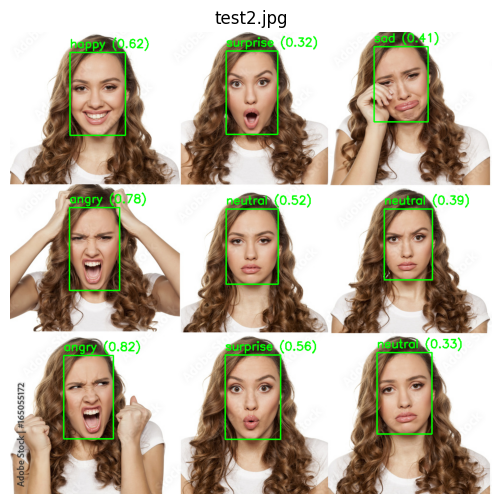


0: 448x640 6 faces, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


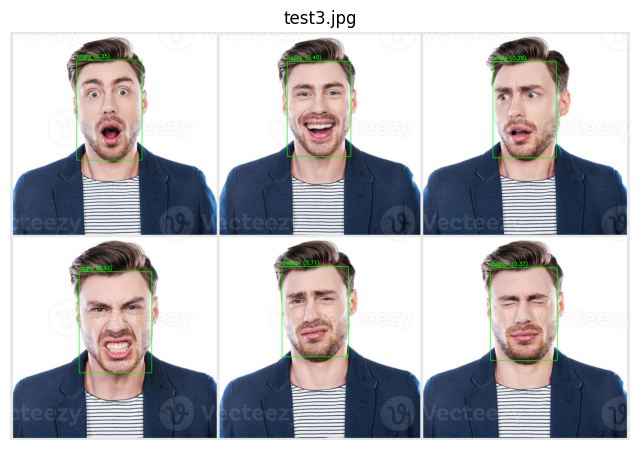


0: 640x480 16 faces, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


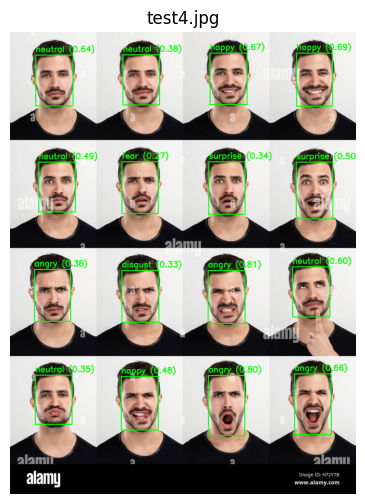


0: 448x640 5 faces, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


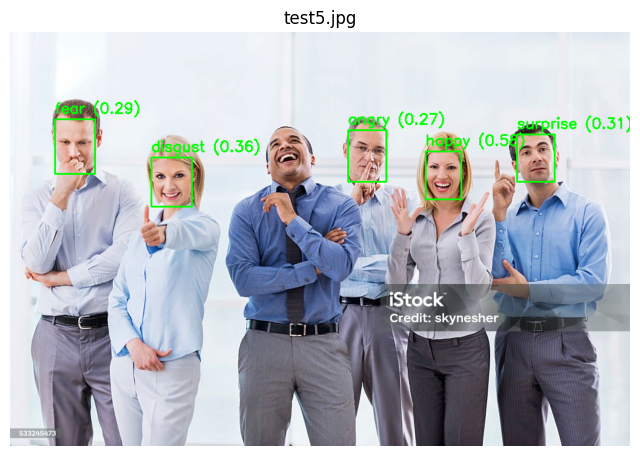


0: 448x640 4 faces, 5.9ms
Speed: 2.3ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


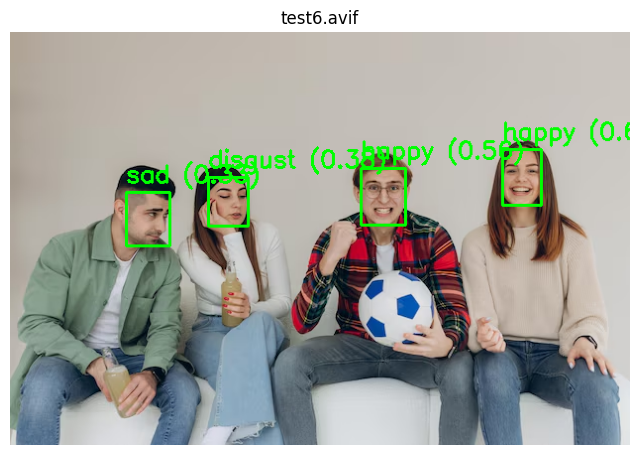


0: 448x640 4 faces, 6.1ms
Speed: 2.1ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


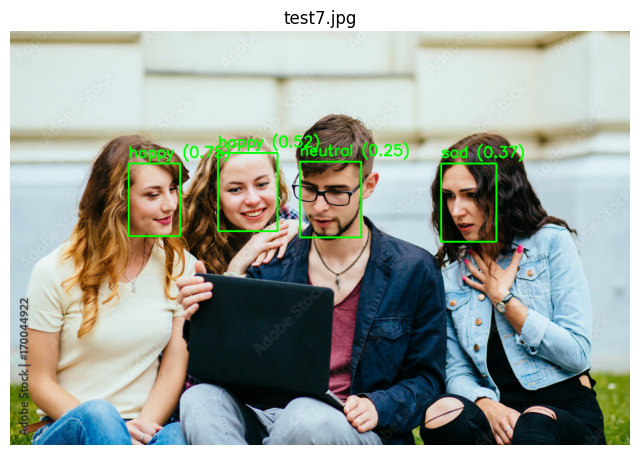

In [85]:
sample_dir = "/kaggle/input/sample-emotion-faces"

image_files = sorted([
    f for f in os.listdir(sample_dir)
    if f.lower().endswith((".jpg", ".avif"))
])

for img_name in image_files:
    img_path = os.path.join(sample_dir, img_name)

    output = infer_faces_and_emotions(
        image_path=img_path,
        face_detector=face_detector, # YOLO model (Face detection)
        emotion_model=emotion_model,  # ResNet (emotion classification)
        emotion_classes=train_dataset.classes
    )

    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title(img_name)
    plt.axis("off")
    plt.show()


<div style="
  background:linear-gradient(90deg,#6366f1,#22c55e);
  color:white;
  padding:16px 22px;
  margin:30px auto 15px auto;
  font-size:24px;
  font-weight:700;
  border-radius:10px;
  box-shadow:0 8px 20px rgba(0,0,0,0.15);
  text-align:center;
  width:50%;
">
  Final Observations on Sample Images
</div>

#

- The YOLO-based face detector successfully identifies multiple faces across varied scales, poses, and lighting conditions.

- High recall in face detection ensures most visible faces are passed to the emotion classifier.

- Occasional false positives are observed, which is acceptable for downstream emotion analysis.

- Emotion predictions are generally consistent with visible facial expressions on clearly aligned faces.

- Performance degrades for partially occluded faces or imperfect crops.

- Emotion ambiguity is most common between visually similar classes (e.g., fear vs surprise, sad vs neutral).

- Detection errors directly propagate to emotion classification results, highlighting pipeline dependency.

# Conclusion 


This project demonstrates a complete, end-to-end facial emotion recognition system that integrates custom-trained face detection with transfer-learned emotion classification.

By combining a YOLO-based face detector trained on the WIDER FACE dataset with a partially fine-tuned ResNet-based emotion classifier trained on FER2013, the system reflects realistic design choices used in practical computer vision applications.

Rather than optimizing solely for benchmark accuracy, the project prioritizes modularity, robustness, and honest evaluation.

<div style="
  background:#111827;
  color:#ffffff;
  padding:14px 20px;
  margin:30px 0 15px 0;
  border-left:6px solid #22c55e;
  font-size:22px;
  font-weight:600;
  border-radius:10px;
  letter-spacing:0.5px;

">
  Emotion Classification Model
</div>




<div style="
  background:#111827;
  color:#ffffff;
  padding:14px 20px;
  margin:30px auto 15px auto;
  border-left:6px solid #22c55e;
  font-size:22px;
  font-weight:600;
  border-radius:55px;
  letter-spacing:0.5px;
    text-align:center;
    width:30%;
">
  <h1>THANK YOU</h1>
</div>
